In [1]:
import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import warnings
import numpy as np
from numpy import quantile, where, random
import pandas as pd

#EDA Tools 
from pandas_profiling import ProfileReport
import dtale

import copy 
import scipy as sp
import scipy.stats as stats
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from math import ceil
import matplotlib.cm as cm

#sklearn Libraries
# For UMAP
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (Normalizer,
                                   MinMaxScaler,
                                   RobustScaler,
                                   StandardScaler,
                                   QuantileTransformer,
                                   PowerTransformer)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.covariance import MinCovDet
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from sklearn.base import clone

import sklearn.preprocessing as prep

#Clusters
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors import KNeighborsClassifier

from kneed import KneeLocator

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

import umap

import logging
log = logging.getLogger('matplotlib')
log.setLevel(logging.WARNING)

warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas_profiling'

In [79]:
# Functions 
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30, color='g')
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    ax = sns.boxplot(y=df[variable], orient="h", palette="Set2", whis=5)
    plt.title('Boxplot')

    plt.show()
    
def diagnostic_check(df):
    for feature in df:
        diagnostic_plots(df, feature)   
    
    return diagnostic_plots
    
    
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1') # 
    plt.show()  
    
# def outlier_quantiles(df):

#     # the boundaries are the quantiles
#     for variable in df.columns:
        
#         lower_limit = df[variable].quantile(0.01)
#         upper_limit = df[variable].quantile(0.99)
    
#         df[variable]= np.where(df[variable].isnull(), df[variable],
#                       np.where(df[variable] > upper_limit, df[variable].mean(),
#                       np.where(df[variable] < lower_limit, df[variable].mean(), df[variable])))
#     return df 


def y2m(x):
    if pd.isnull(x) == True:
        return (x)
    else:
        return((2020- (int(x[0:4])))*12 - int(x[5:7]))
    
# data_1st['LASTDATE'] = data_1st['LASTDATE'].map(lambda x:y2m(x))

# data_1st['FISTDATE'] = data_1st['FISTDATE'].map(lambda x:y2m(x))


    
#Tukey's method - Outliers 
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss

#print(probable_outliers_tm)
#print(possible_outliers_tm)

# Function to run turkeys method to the dataframe.
def outliers(df):
    liers= []
    for features in df:
        prob = tukeys_method(df, features)[0]
        liers = liers + prob
    to_drop = np.unique(liers)
    df_nout = df.drop(to_drop,axis = 0)
    return(df_nout)

# Class cluster profiles code
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
#         cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]

        cluster_labels = ["{}".format(i) for i in handles]
    
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=20, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle(".", fontsize=23)
    plt.show()

In [4]:
data = pd.read_csv('Selected_features-7.6age.csv')
data.drop('Unnamed: 0',axis=1, inplace=True)

In [5]:
data.head()

RAMNTALL  NGIFTALL  FISTDATE    IC1  HHAS4  VOC2  LFC1    EC1  EIC9  \
0     240.0      31.0     121.0  307.0    1.0  77.0  56.0  120.0   6.0   
1     202.0      27.0     119.0  251.0   11.0  65.0  65.0  120.0   3.0   
2     109.0      16.0     154.0  386.0   20.0  43.0  69.0  120.0   3.0   
3      51.0       4.0      71.0  364.0    8.0  72.0  67.0  120.0   5.0   
4     107.0      14.0     155.0  251.0    3.0  56.0  54.0  120.0   5.0   

      HV2  MHUC1   AGE  
0   635.0    6.0  63.0  
1   546.0    9.0  90.0  
2  1263.0   16.0  72.0  
3   899.0    9.0  66.0  
4   519.0    5.0  40.0

## Data Normalization

In [6]:
df_minmax = data.copy()#data.copy()

In [7]:
metric_features = data.columns.values

In [8]:
# We tried other scaling but this was the one with best results. 

scaler = MinMaxScaler()#Normalizer()#RobustScaler()#StandardScaler()
scaled_feat = scaler.fit_transform(df_minmax[metric_features])
scaled_feat

array([[0.47193347, 0.58823529, 0.66086957, ..., 0.14363266, 0.3       ,
        0.5546875 ],
       [0.39293139, 0.50980392, 0.64347826, ..., 0.12350147, 0.45      ,
        0.765625  ],
       [0.1995842 , 0.29411765, 0.94782609, ..., 0.28568197, 0.8       ,
        0.625     ],
       ...,
       [0.02494802, 0.        , 0.00869565, ..., 0.231848  , 0.8       ,
        0.640625  ],
       [0.01455301, 0.        , 0.        , ..., 0.38973083, 0.9       ,
        0.453125  ],
       [0.09355509, 0.11764706, 0.14782609, ..., 0.08527482, 0.25      ,
        0.546875  ]])

In [9]:
df_minmax[metric_features] = scaled_feat
# df_minmax.head(10)

In [ ]:
# sns.pairplot(df_minmax)

In [14]:
cor_nor = df_minmax.corr(method = "pearson") 

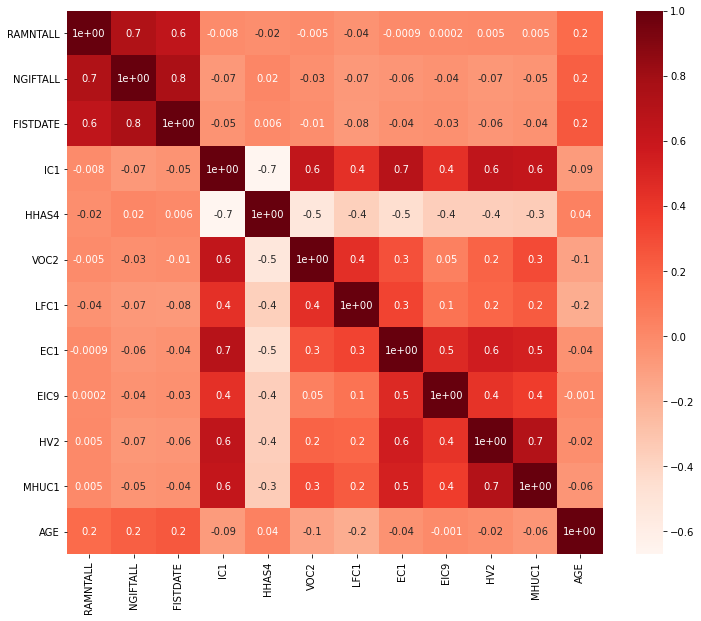

In [15]:
cor_heatmap(cor_nor)

In [ ]:
# diagnostic_check(df_minmax)

### Gift check

In [16]:
gift3 = df_minmax[['RAMNTALL', 'NGIFTALL', 'FISTDATE']]

In [17]:
cor_gift3 = gift3.corr(method = "pearson") 

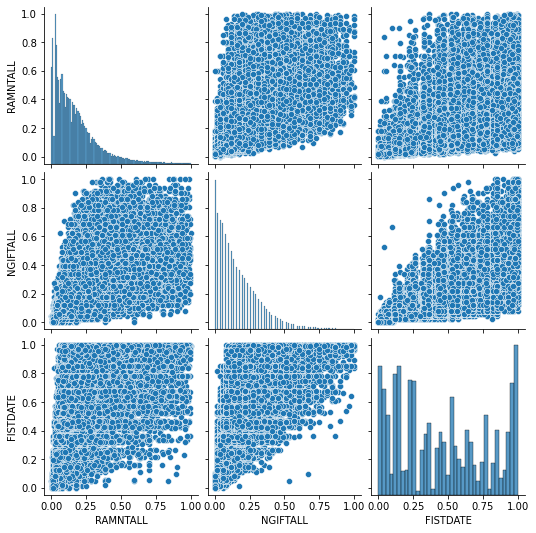

In [18]:
sns.pairplot(gift3)

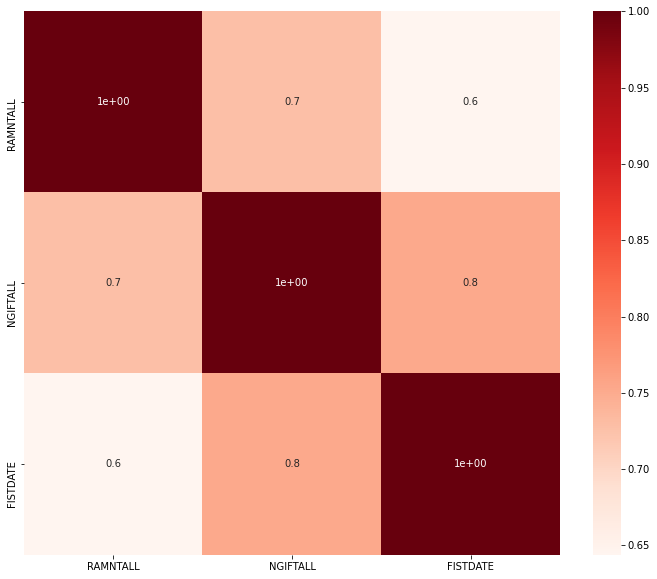

In [19]:
cor_heatmap(cor_gift3)

##### Neighborhood check 

In [20]:
Neighborhood3 = df_minmax[['IC1', 'HHAS4', 'VOC2', 'LFC1', 'EC1', 'EIC9', 'HV2', 'MHUC1']]

In [ ]:
# Neighborhood3 = df_minmax[['AGE904','IC1', 'HHAS4', 'EC1', 'VOC2']]

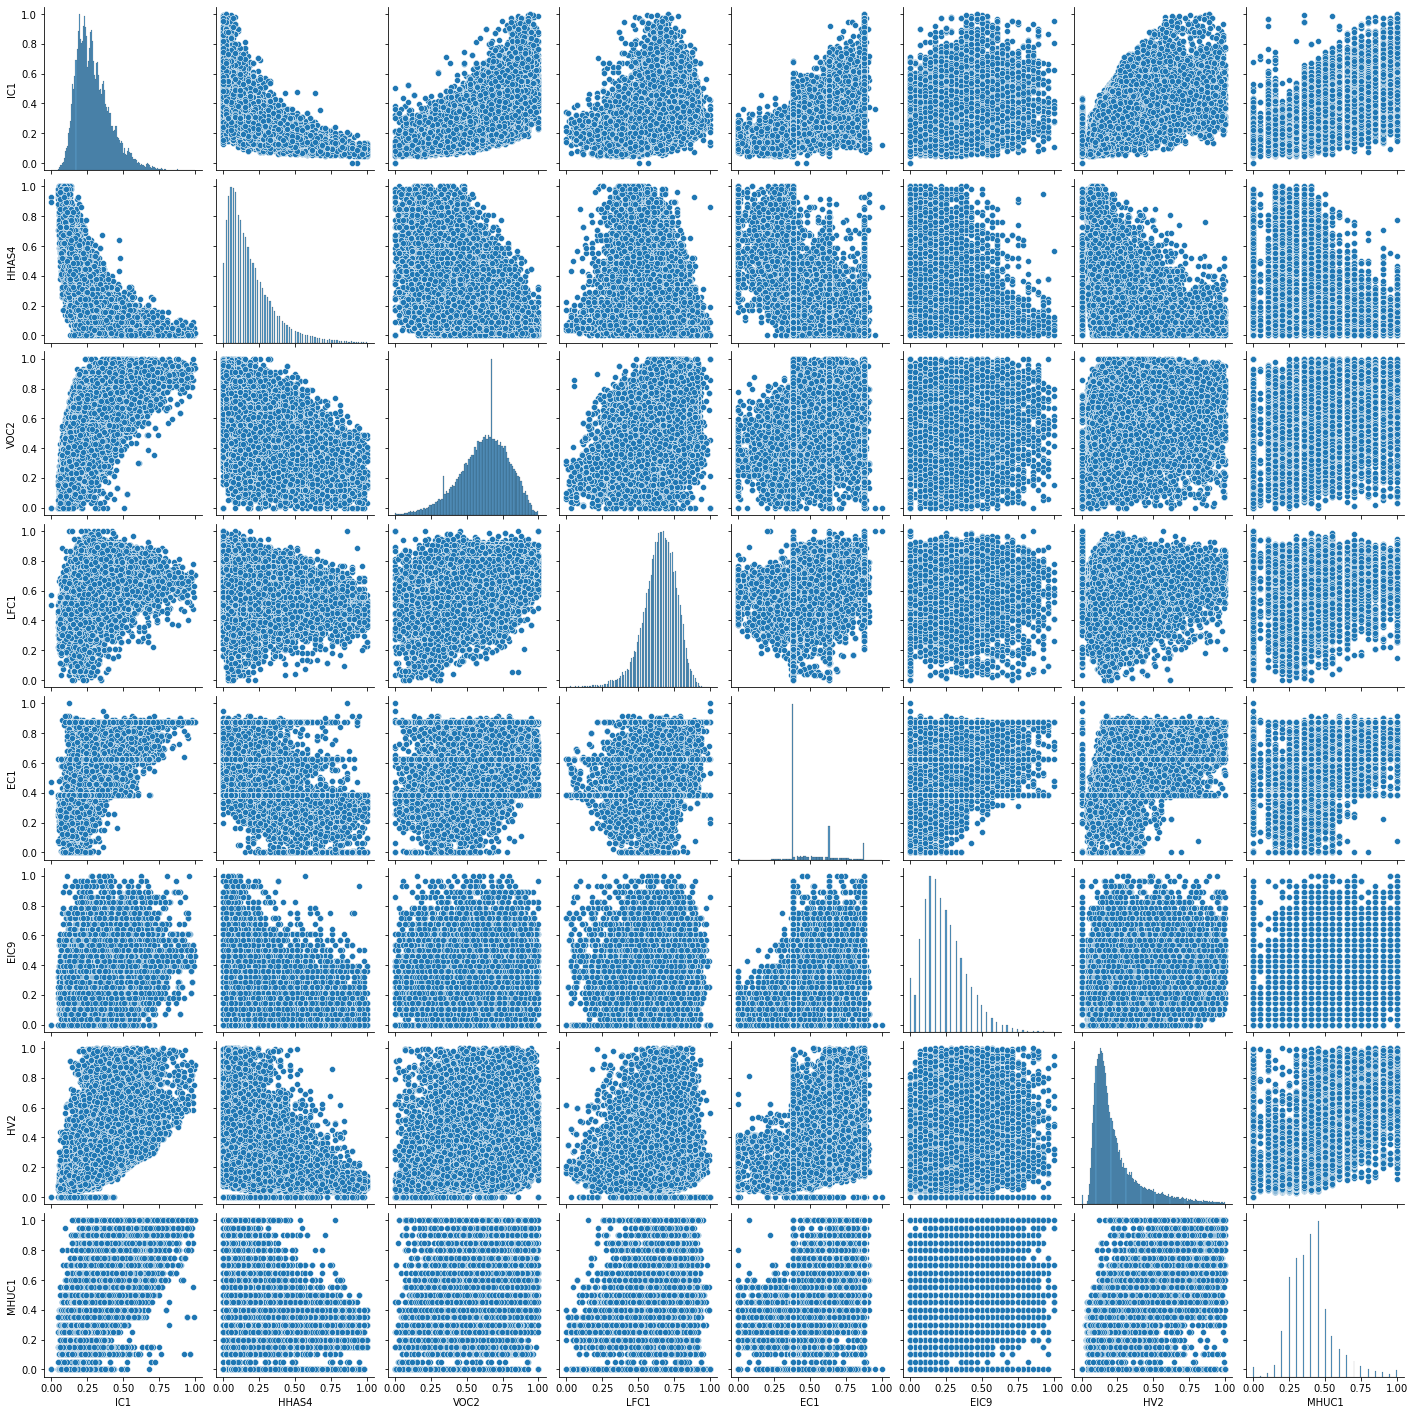

In [21]:
sns.pairplot(Neighborhood3)

In [22]:
cor_neighb3 = Neighborhood3.corr(method = "pearson") 

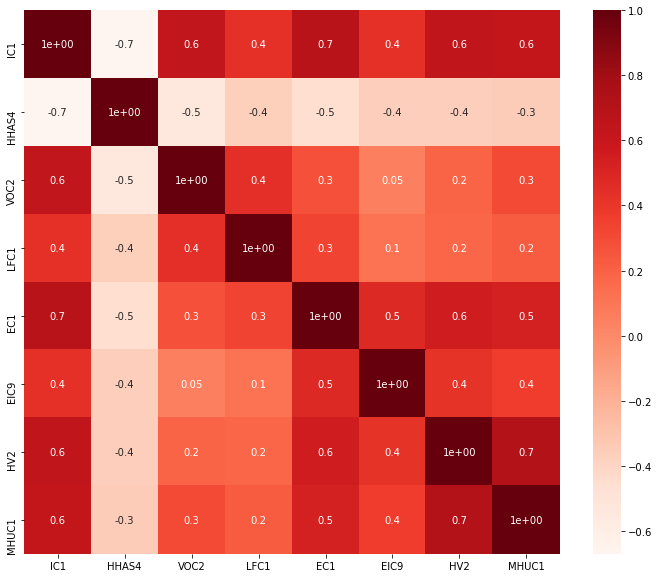

In [23]:
cor_heatmap(cor_neighb3)

# Clustering

## Gift Clustering

In [11]:
gift = df_minmax[['FISTDATE','NGIFTALL','RAMNTALL']]

In [12]:
gift.columns

Index(['FISTDATE', 'NGIFTALL', 'RAMNTALL'], dtype='object')

In [13]:
gift.columns = ['1st_gift_date','Number_gifts','Amount_gifts']

In [14]:
gift.head()

1st_gift_date  Number_gifts  Amount_gifts
0       0.660870      0.588235      0.471933
1       0.643478      0.509804      0.392931
2       0.947826      0.294118      0.199584
3       0.226087      0.058824      0.079002
4       0.956522      0.254902      0.195426

In [15]:
gift_features = gift.columns #np.array(gift.columns) #
gift_features

Index(['1st_gift_date', 'Number_gifts', 'Amount_gifts'], dtype='object')

### Finding the optimal clusterer on gift variables

### Kmeans 

### Characteristics:
- *Number of clusters* need to be set apriori
- One of the *fastest* clustering algorithms
- The results *depend on the initialization* (stochastic)
- Prone to *local optima*
- Favors *convex* (round shape) and *isotropic* (same shape) clusters

*init='k-means++'* initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization. *n_init=K* allows to initialize KMeans K times and pick the best clustering in terms of Inertia. This can been shown in the link below.

### Defining the number of clusters:

In [29]:
range_clusters = range(2, 10)

In [30]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=42)
    kmclust.fit(gift)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

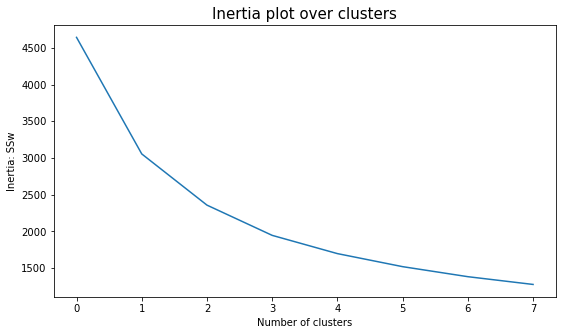

In [31]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [33]:
kl = KneeLocator(
    range(2, 10), inertia, curve="convex", direction="decreasing"
    )

number_clusters1 = kl.elbow
number_clusters1

4

In [32]:
# In here we want the elbow, the inflection point with lower inertia, so from here we can go between 2 and 4. Hierquical clustering give us a 3 solution clustering, let's try and double check with the silhouette score. 

In [35]:
clusters_try = number_clusters1+1

# Silhouette for Gift

For n_clusters = 2, the average silhouette_score is : 0.5580689200492257
For n_clusters = 3, the average silhouette_score is : 0.47728482311103426
For n_clusters = 4, the average silhouette_score is : 0.47149764959644763


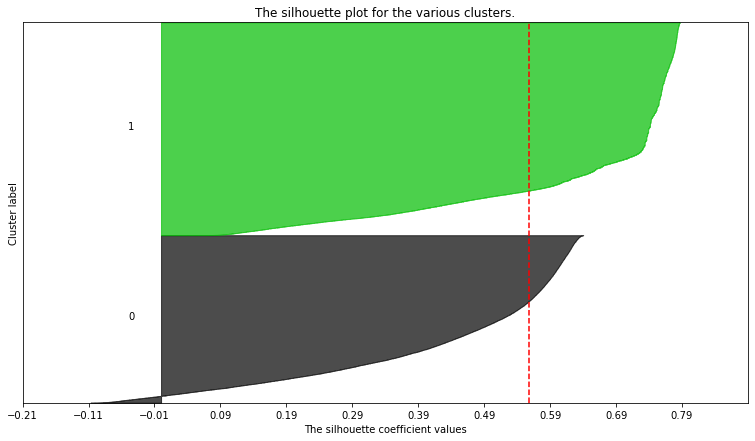

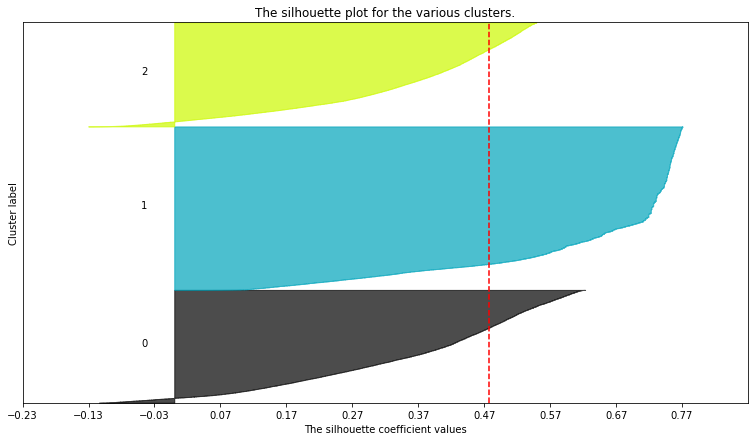

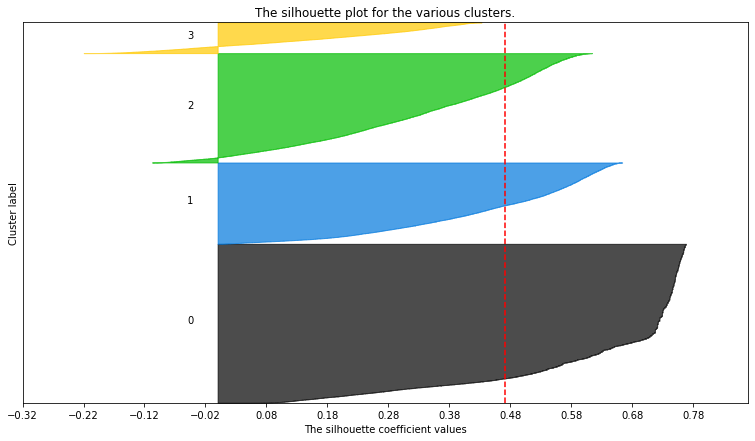

In [36]:
# Final Solution
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
range_clusters_silhouette_gift = range(2,clusters_try)
avg_silhouette = []
for nclus in range_clusters_silhouette_gift:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=20, random_state=42)
    cluster_labels = kmclust.fit_predict(gift)
#--------------------------------------------------------------------------------------------------------------------------
    #cluster_labels=km_labels_neighb
#---------------------------------------------------------------------------------------------------------------
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(gift, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(gift, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(gift) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

- double check on this values. 
- https://stats.stackexchange.com/questions/10540/how-to-interpret-mean-of-silhouette-plot

0.71 - 1.0
A strong structure has been found

0.51 - 0.70
A reasonable structure has been found

0.26 - 0.50
The structure is weak and could be artificial. Try additional methods of data analysis.

< 0.25
No substantial structure has been found

In [37]:
# # The average silhouette plot
# # The inertia plot
# plt.figure(figsize=(9,5))
# plt.plot(avg_silhouette)
# plt.ylabel("Average silhouette")
# plt.xlabel("Number of clusters")
# plt.title("Average silhouette plot over clusters", size=15)
# plt.show()

### Final KMeans clustering solution

In [16]:
# final cluster solution
#number_clusters = 4
kmclust = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42)
km_labels = kmclust.fit_predict(gift[gift_features])
km_labels

array([0, 0, 0, ..., 1, 1, 1])

In [17]:
# Characterizing the final clusters
df_concat = pd.concat((gift, pd.Series(km_labels, name='labels_gift')), axis=1)
df_concat.groupby('labels_gift').mean()

1st_gift_date  Number_gifts  Amount_gifts
labels_gift                                           
0                 0.778266      0.283602      0.286533
1                 0.210174      0.068728      0.084416

In [18]:
frame = df_concat
frame['cluster'] = km_labels
frame['cluster'].value_counts()

1    49399
0    38891
Name: cluster, dtype: int64

In [19]:
df_concat.drop(['cluster'],axis=1,inplace=True)

In [20]:
# sns.pairplot(df_concat.sample(n=10000),hue='labels_gift',palette='Dark2',diag_kind='kde')

In [21]:
df_concat.head()

1st_gift_date  Number_gifts  Amount_gifts  labels_gift
0       0.660870      0.588235      0.471933            0
1       0.643478      0.509804      0.392931            0
2       0.947826      0.294118      0.199584            0
3       0.226087      0.058824      0.079002            1
4       0.956522      0.254902      0.195426            0

In [22]:
df_concat['labels_gift'] = df_concat['labels_gift'].map(lambda x: 'Old_donor' if x==0 else 'Recent_donor')

### Hierarchical cluster number check

In [23]:
# Centroids of the concatenated cluster labels
df_centroids_gift = df_concat.groupby('labels_gift')\
    [gift_features].mean()
df_centroids_gift

1st_gift_date  Number_gifts  Amount_gifts
labels_gift                                            
Old_donor          0.778266      0.283602      0.286533
Recent_donor       0.210174      0.068728      0.084416

In [24]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids_gift)

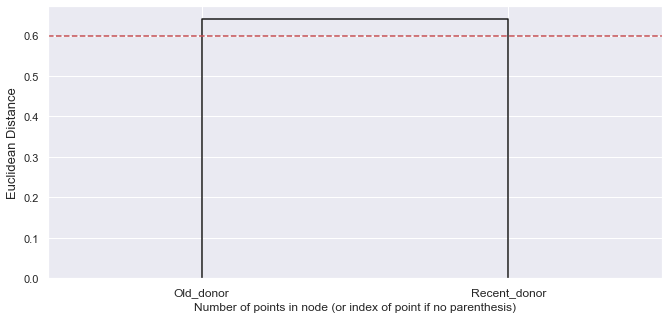

In [25]:
#  Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.6
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids_gift.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
#plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

## SOM - Self Organizing maps

In [48]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge
sm = sompy.SOMFactory().build(
    gift.values, 
    mapsize=(25, 25), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=gift_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 9.000000 , radius_final: 1.500000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.234000, quantization error: 0.300576

 epoch: 2 ---> elapsed time:  0.231000, quantization error: 1.480881

 epoch: 3 ---> elapsed time:  0.231000, quantization error: 1.397387

 epoch: 4 ---> elapsed time:  0.233000, quantization error: 1.393128

 epoch: 5 ---> elapsed time:  0.230000, quantization error: 1.370749

 epoch: 6 ---> elapsed time:  0.241000, quantization error: 1.368123

 epoch: 7 ---> elapsed time:  0.235000, quantization error: 1.365807

 epoch: 8 ---> elapsed time:  0.233000, quantization error: 1.363436

 epoch: 9 ---> elapsed time:  0.231000, quantization error: 1.361008

 epoch: 10 ---> elapsed time:  0.234000, quantization error: 1.358519

 epoch: 11 ---> elapsed time:  0.235000, quantization error: 1.355966

 epoch: 12 ---> elapsed time:  0.229000, quantization error: 1.353351

 epoch: 13 ---> 

In [49]:
# Coordinates of the units in the input space
sm.get_node_vectors()

array([[0.49929564, 0.06193722, 0.06781984],
       [0.46275557, 0.05998929, 0.06641407],
       [0.42394101, 0.05620597, 0.0627403 ],
       ...,
       [0.48341423, 0.16379588, 0.35877073],
       [0.45218425, 0.15740672, 0.3935317 ],
       [0.41053682, 0.15274567, 0.43543821]])

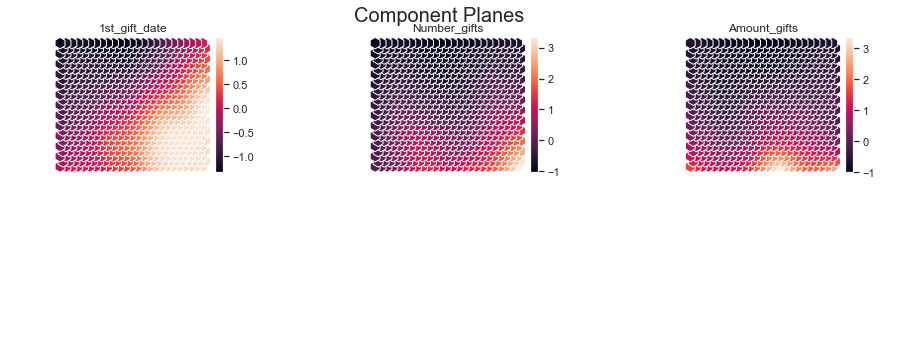

In [50]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

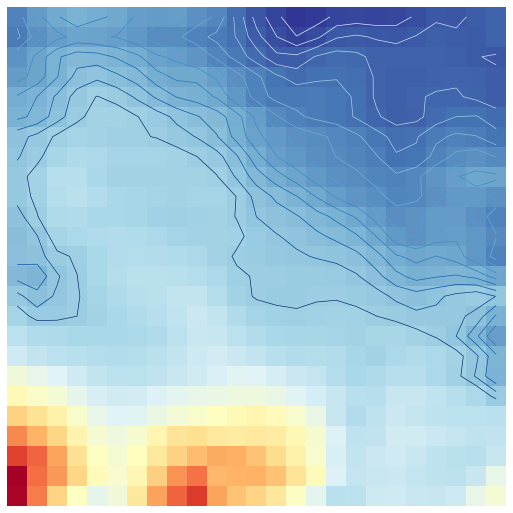

In [51]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)

In [52]:
# # Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
# kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=5)
# nodeclus_labels = sm.cluster(kmeans)

# hits  = HitMapView(12, 12,"Clustering", text_size=10)
# hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

# plt.show()

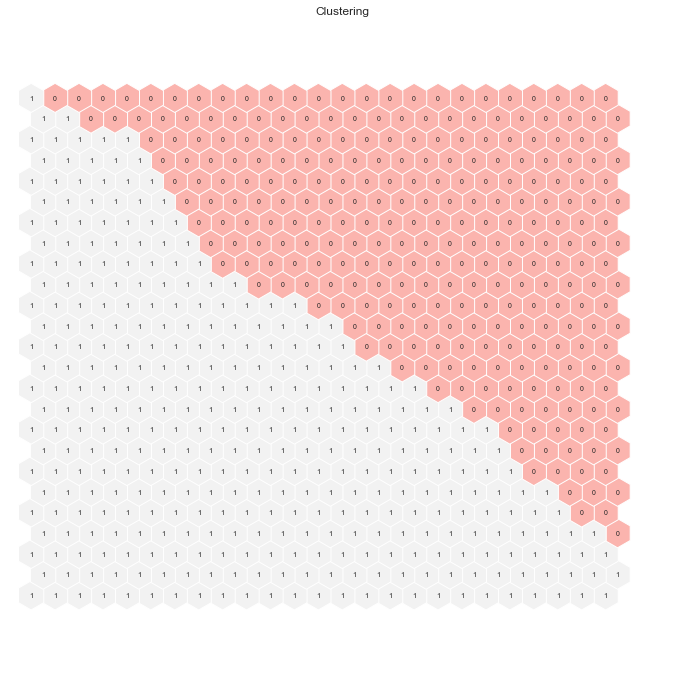

In [53]:
# Try SOM after our K-means
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
nodeclus_labels = sm.cluster(kmclust)

hits  = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Cluster analysis Gift

In [54]:
df_concat.head()

1st_gift_date  Number_gifts  Amount_gifts   labels_gift
0       0.660870      0.588235      0.471933  Recent_donor
1       0.643478      0.509804      0.392931  Recent_donor
2       0.947826      0.294118      0.199584  Recent_donor
3       0.226087      0.058824      0.079002     Old_donor
4       0.956522      0.254902      0.195426  Recent_donor

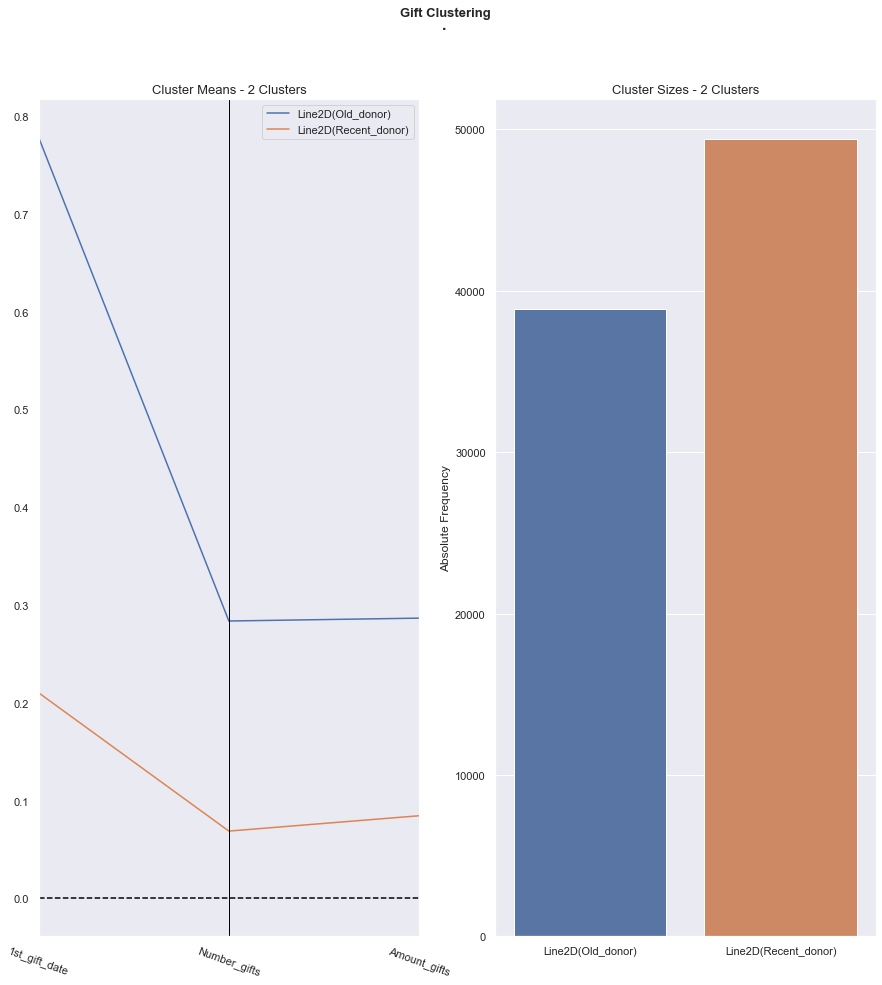

In [29]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_concat[gift_features.to_list() + ['labels_gift']], 
    label_columns = ['labels_gift'], 
    figsize = (15, 15), 
    compar_titles = ["Gift Clustering"]
)

## UMAP

In [56]:
standard_embedding_gift = umap.UMAP(random_state=5).fit_transform(gift[gift_features])

In [59]:
plt.scatter(standard_embedding_gift[:, 0], standard_embedding_gift[:, 1], c=df_concat['labels_gift'].astype(int), s=0.1, cmap='Spectral');

## T-SNE

In [61]:
# This is step can be quite time consuming
two_dim_gift = TSNE(random_state=5).fit_transform(gift[gift_features])

In [ ]:
# t-SNE visualization
pd.DataFrame(two_dim_gift).plot.scatter(x=0, y=1, c=df_concat['labels_gift'], colormap='tab10', figsize=(15,10))
plt.show() 

# Neighborhood Clustering

In [31]:
neighbor = df_minmax[['IC1', 'HHAS4', 'VOC2', 'LFC1', 'EC1', 'EIC9', 'HV2', 'MHUC1']]#, 'AGE907'

In [32]:
neighbor.columns = ['Average_income','Poverty','2plus_vehicles','Labor_Force','Education','Finance_labor','House_value','Mortages']

In [33]:
neighbor.head()

Average_income   Poverty  2plus_vehicles  Labor_Force  Education  \
0        0.269298  0.017241        0.777778     0.547368   0.382716   
1        0.220175  0.189655        0.656566     0.642105   0.382716   
2        0.338596  0.344828        0.434343     0.684211   0.382716   
3        0.319298  0.137931        0.727273     0.663158   0.382716   
4        0.220175  0.051724        0.565657     0.526316   0.382716   

   Finance_labor  House_value  Mortages  
0       0.214286     0.143633      0.30  
1       0.107143     0.123501      0.45  
2       0.107143     0.285682      0.80  
3       0.178571     0.203348      0.45  
4       0.178571     0.117394      0.25

In [34]:
neighb_features = neighbor.columns

## Kmeans

### Characteristics:
- *Number of clusters* need to be set apriori
- One of the *fastest* clustering algorithms
- The results *depend on the initialization* (stochastic)
- Prone to *local optima*
- Favors *convex* (round shape) and *isotropic* (same shape) clusters

*init='k-means++'* initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization. *n_init=K* allows to initialize KMeans K times and pick the best clustering in terms of Inertia. This can been shown in the link below.

### Defining the number of clusters:

In [66]:
range_clusters_neighb = range(2, 10)

In [67]:
inertia2 = []
for n_clus in range_clusters_neighb:  # iterate over desired ncluster range
    kmclust2 = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=42)
    kmclust2.fit(neighbor)
    inertia2.append(kmclust2.inertia_)  # save the inertia of the given cluster solution

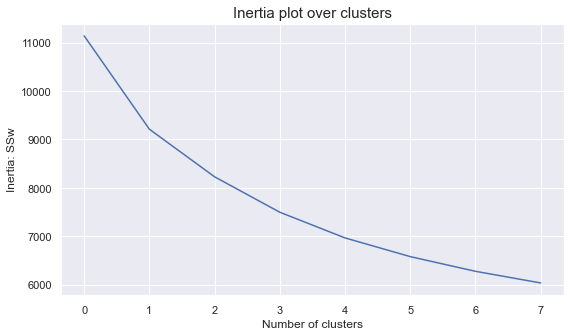

In [68]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia2)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [69]:
# In here we want the elbow, the inflection point with lower inertia, so from here we can go between 2 and 4. Hierquical clustering give us a 3 solution clustering, let's try and double check with the silhouette score. 

In [70]:
kl = KneeLocator(
    range(2, 10), inertia2, curve="convex", direction="decreasing"
    )

number_clusters2 = kl.elbow
number_clusters2

5

In [71]:
clusters_check_neigbh = number_clusters2 + 1

# Silhouette for Neighbor

For n_clusters = 2, the average silhouette_score is : 0.31963065329058615
For n_clusters = 3, the average silhouette_score is : 0.21966210727477212
For n_clusters = 4, the average silhouette_score is : 0.19866515651054895
For n_clusters = 5, the average silhouette_score is : 0.20781065165276816


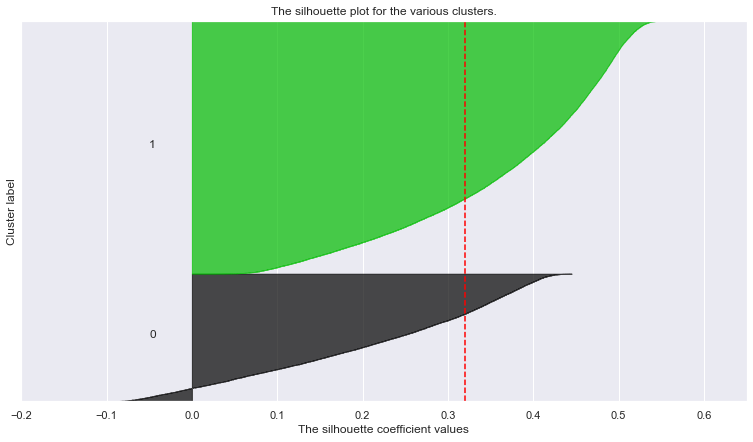

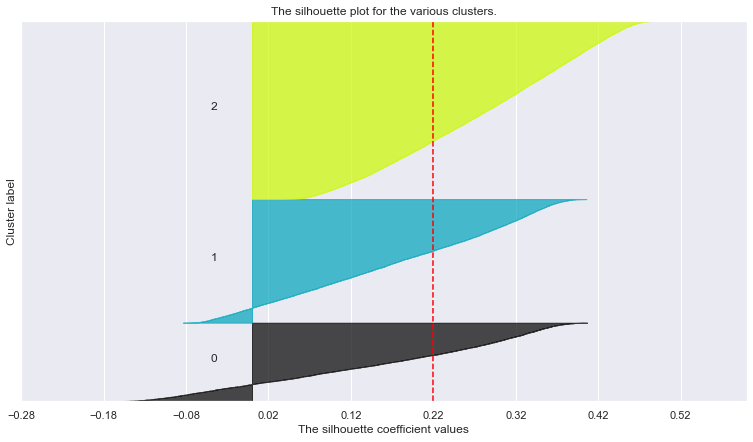

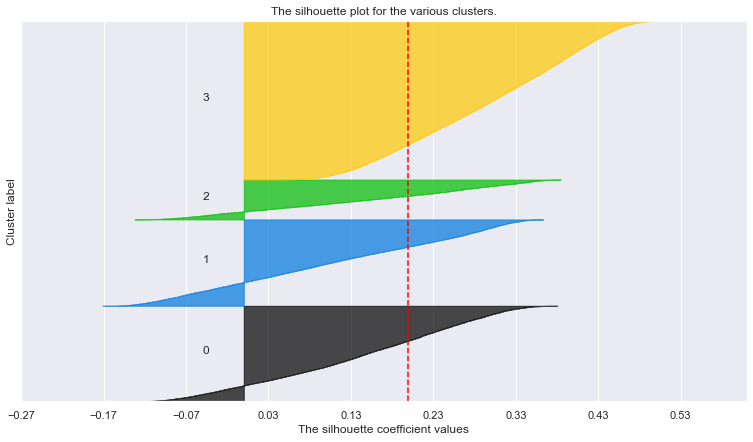

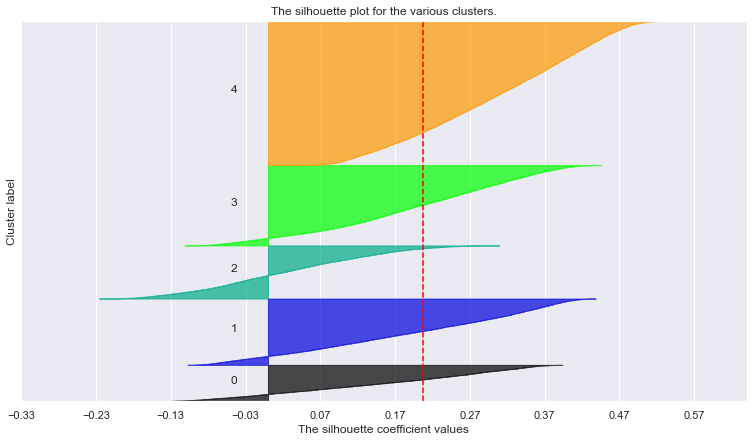

In [72]:
# Final Solution
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
range_clusters_silhouette_neighb = range(2,clusters_check_neigbh)
avg_silhouette = []
for nclus in range_clusters_silhouette_neighb:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=20, random_state=42)
    cluster_labels = kmclust.fit_predict(neighbor)
#--------------------------------------------------------------------------------------------------------------------------
    #cluster_labels=km_labels_neighb
#---------------------------------------------------------------------------------------------------------------
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(neighbor, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(neighbor, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(neighbor) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

- double check on this values. 
- https://stats.stackexchange.com/questions/10540/how-to-interpret-mean-of-silhouette-plot

0.71 - 1.0
A strong structure has been found

0.51 - 0.70
A reasonable structure has been found

0.26 - 0.50
The structure is weak and could be artificial. Try additional methods of data analysis.

< 0.25
No substantial structure has been found

In [ ]:
# # The average silhouette plot
# # The inertia plot
# plt.figure(figsize=(9,5))
# plt.plot(avg_silhouette)
# plt.ylabel("Average silhouette")
# plt.xlabel("Number of clusters")
# plt.title("Average silhouette plot over clusters", size=15)
# plt.show()

### Final KMeans clustering solution

In [35]:
# final cluster solution
# number_clusters = 3
kmclust_neighb = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=5)
km_labels_neighb = kmclust_neighb.fit_predict(neighbor[neighb_features])
km_labels_neighb

array([0, 0, 0, ..., 3, 1, 2])

In [36]:
# Characterizing the final clusters
df_concat_neighb = pd.concat((neighbor, pd.Series(km_labels_neighb, name='labels_neighborhood')), axis=1)
df_concat_neighb.groupby('labels_neighborhood').mean()

Average_income   Poverty  2plus_vehicles  Labor_Force  \
labels_neighborhood                                                          
0                          0.261811  0.161000        0.654985     0.651315   
1                          0.493466  0.075444        0.707254     0.689363   
2                          0.172098  0.389537        0.424122     0.543272   
3                          0.380509  0.079798        0.707066     0.717225   

                     Education  Finance_labor  House_value  Mortages  
labels_neighborhood                                                   
0                     0.403651       0.182900     0.167887  0.350380  
1                     0.717086       0.393195     0.634437  0.698967  
2                     0.387975       0.181398     0.146810  0.310950  
3                     0.622306       0.326022     0.292068  0.455917

In [37]:
frame = df_concat_neighb
frame['cluster'] = km_labels_neighb
frame['cluster'].value_counts()

0    37080
3    22040
2    19973
1     9197
Name: cluster, dtype: int64

In [38]:
df_concat_neighb.drop(['cluster'],axis=1,inplace=True)

In [39]:
# sns.pairplot(df_concat_neighb.sample(n=10000),hue='labels_neighborhood',palette='Dark2',diag_kind='kde')

In [40]:
df_concat_neighb['labels_neighborhood'] = df_concat_neighb['labels_neighborhood'].map(lambda x: 'Medium_low_inc' if x==0 else x)

In [41]:
df_concat_neighb['labels_neighborhood'] = df_concat_neighb['labels_neighborhood'].map(lambda x: 'High_inc' if x==1 else x)

In [42]:
df_concat_neighb['labels_neighborhood'] = df_concat_neighb['labels_neighborhood'].map(lambda x: 'Low_inc' if x==2 else x)

In [43]:
df_concat_neighb['labels_neighborhood'] = df_concat_neighb['labels_neighborhood'].map(lambda x: 'Medium_high_inc' if x==3 else x)

In [44]:
df_concat_neighb

Average_income   Poverty  2plus_vehicles  Labor_Force  Education  \
0            0.269298  0.017241        0.777778     0.547368   0.382716   
1            0.220175  0.189655        0.656566     0.642105   0.382716   
2            0.338596  0.344828        0.434343     0.684211   0.382716   
3            0.319298  0.137931        0.727273     0.663158   0.382716   
4            0.220175  0.051724        0.565657     0.526316   0.382716   
...               ...       ...             ...          ...        ...   
88285        0.196491  0.137931        0.484848     0.378947   0.382716   
88286        0.250000  0.293103        0.727273     0.663158   0.382716   
88287        0.379825  0.103448        0.606061     0.810526   0.580247   
88288        0.707018  0.120690        0.848485     0.726316   0.876543   
88289        0.230702  0.448276        0.424242     0.684211   0.382716   

       Finance_labor  House_value  Mortages labels_neighborhood  
0           0.214286     0.143633      0.30      Medium_low_inc  
1           0.107143     0.123501      0.45      Medium_low_inc  
2           0.107143     0.285682      0.80      Medium_low_inc  
3           0.178571     0.203348      0.45      Medium_low_inc  
4           0.178571     0.117394      0.25      Medium_low_inc  
...              ...          ...       ...                 ...  
88285       0.107143     0.302194      0.15             Low_inc  
88286       0.142857     0.197919      0.30      Medium_low_inc  
88287       0.250000     0.231848      0.80     Medium_high_inc  
88288       0.321429     0.389731      0.90            High_inc  
88289       0.178571     0.085275      0.25             Low_inc  

[88290 rows x 9 columns]

### Hierarchical clustering 

In [141]:
# Centroids of the concatenated cluster labels
df_centroids_neighb = df_concat_neighb.groupby('labels_neighborhood')\
    [neighb_features].mean()
df_centroids_neighb

Average_income   Poverty  2plus_vehicles  Labor_Force  \
labels_neighborhood                                                          
4                          0.252499  0.157321        0.440234     0.584724   
High_inc                   0.402299  0.068972        0.756398     0.732035   
Low_inc                    0.260493  0.166297        0.669615     0.654318   
Medium_high_inc            0.499661  0.073021        0.713276     0.691727   
Medium_low_inc             0.160988  0.444984        0.443287     0.553480   

                     Education  Finance_labor  House_value  Mortages  
labels_neighborhood                                                   
4                     0.486600       0.354623     0.270014  0.391867  
High_inc              0.629820       0.307633     0.287808  0.461752  
Low_inc               0.400091       0.166385     0.159908  0.347141  
Medium_high_inc       0.723655       0.396238     0.644378  0.706956  
Medium_low_inc        0.373365       0.140519     0.123554  0.299734

In [142]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids_neighb)

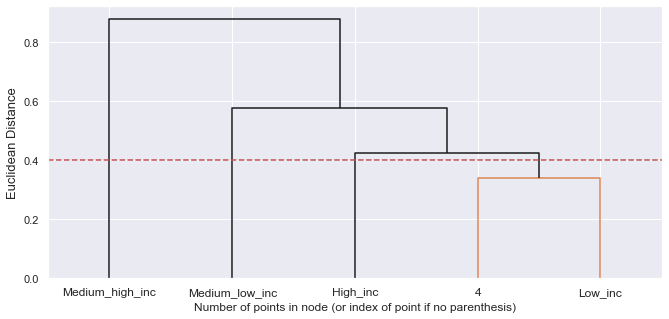

In [144]:
#  Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.4
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids_neighb.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
#plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

## SOM - Self Organizing maps

In [86]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge
sm = sompy.SOMFactory().build(
    neighbor.values, 
    mapsize=(25, 25), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=neighb_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 9.000000 , radius_final: 1.500000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.236000, quantization error: 2.595168

 epoch: 2 ---> elapsed time:  0.242000, quantization error: 2.540454

 epoch: 3 ---> elapsed time:  0.243000, quantization error: 2.461726

 epoch: 4 ---> elapsed time:  0.238000, quantization error: 2.441750

 epoch: 5 ---> elapsed time:  0.235000, quantization error: 2.428227

 epoch: 6 ---> elapsed time:  0.236000, quantization error: 2.420196

 epoch: 7 ---> elapsed time:  0.239000, quantization error: 2.417326

 epoch: 8 ---> elapsed time:  0.235000, quantization error: 2.414857

 epoch: 9 ---> elapsed time:  0.238000, quantization error: 2.412342

 epoch: 10 ---> elapsed time:  0.235000, quantization error: 2.409763

 epoch: 11 ---> elapsed time:  0.237000, quantization error: 2.407119

 epoch: 12 ---> elapsed time:  0.236000, quantization error: 2.404410

 epoch: 13 ---> 

In [87]:
# Coordinates of the units in the input space
sm.get_node_vectors()

array([[0.38036235, 0.06042378, 0.82740021, ..., 0.18707705, 0.21075073,
        0.39771675],
       [0.36496839, 0.06612803, 0.80807393, ..., 0.2157873 , 0.20193807,
        0.39122774],
       [0.35635523, 0.07047009, 0.7936098 , ..., 0.25545035, 0.19642414,
        0.38380989],
       ...,
       [0.22025588, 0.14739758, 0.3935685 , ..., 0.37077709, 0.21386707,
        0.33883921],
       [0.22009429, 0.13641196, 0.36149589, ..., 0.36606475, 0.22845542,
        0.34262768],
       [0.21895725, 0.1266809 , 0.31183404, ..., 0.37349484, 0.23849014,
        0.32569512]])

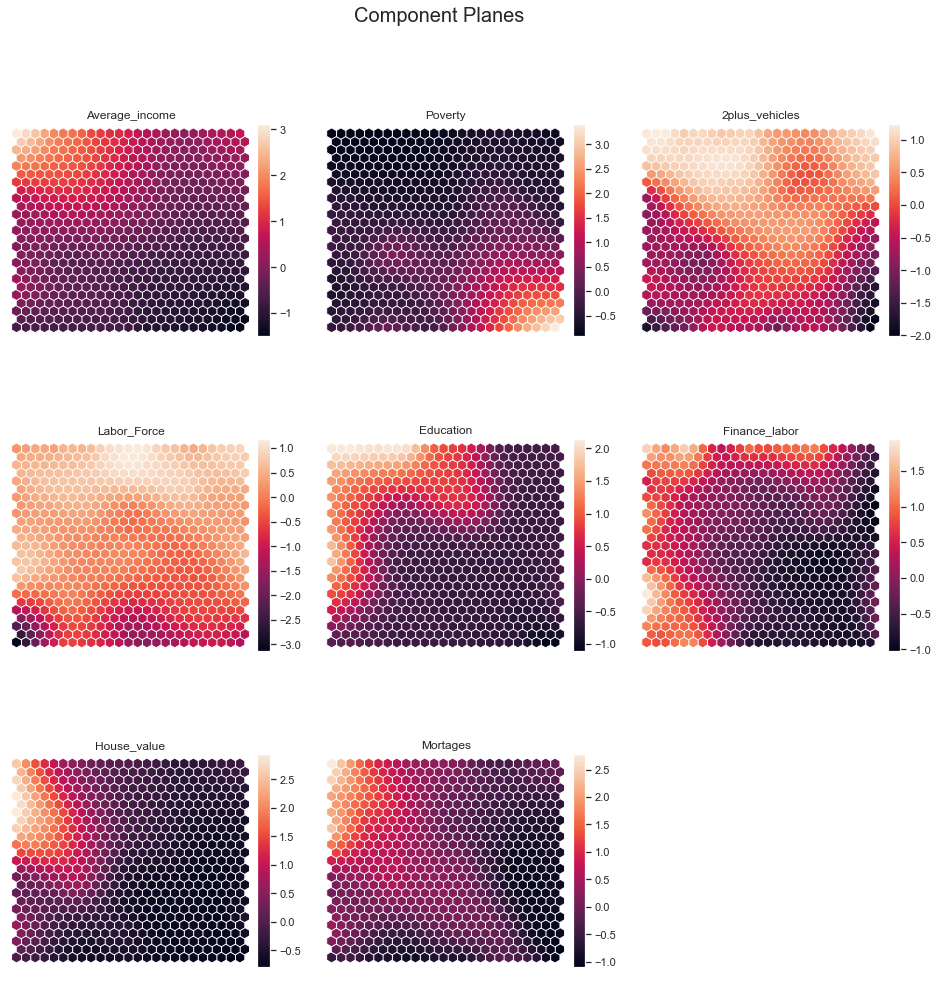

In [88]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

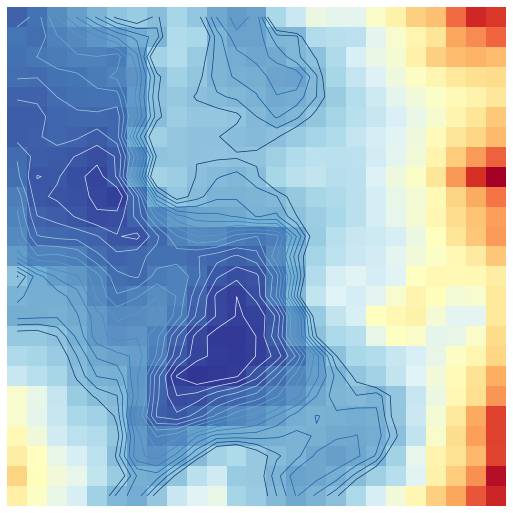

In [89]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)

In [90]:
# # Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
# kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=5)
# nodeclus_labels = sm.cluster(kmeans)

# hits  = HitMapView(12, 12,"Clustering", text_size=10)
# hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

# plt.show()

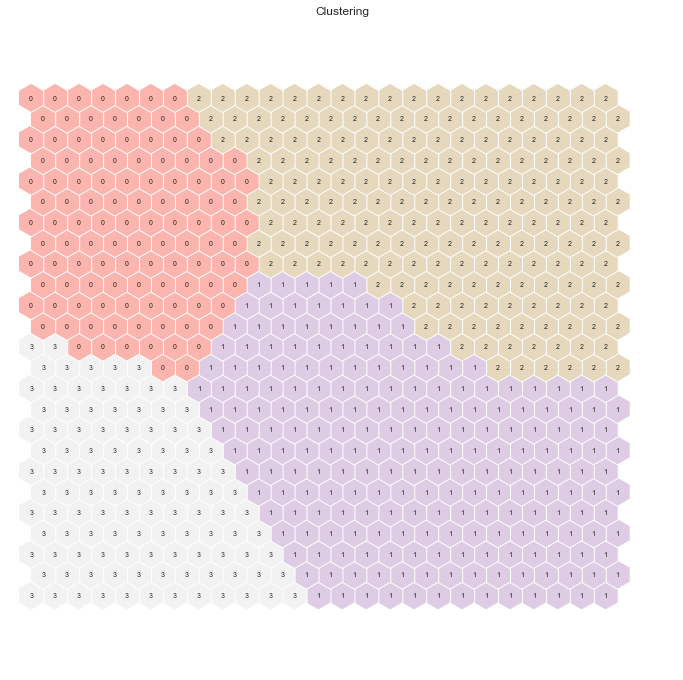

In [91]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
nodeclus_labels = sm.cluster(kmclust_neighb)

hits  = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Cluster analysis Neighborhood

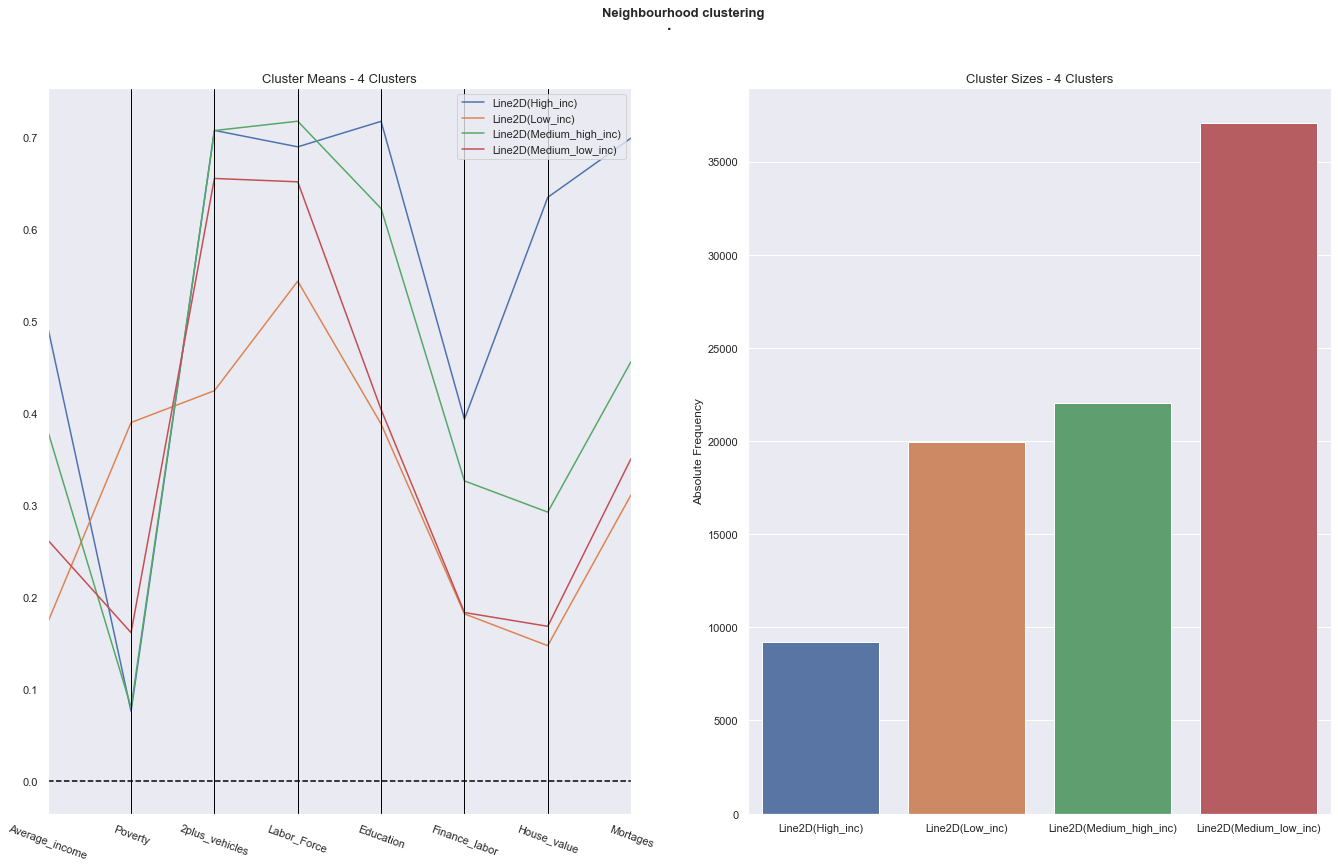

In [46]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_concat_neighb[neighb_features.to_list() + ['labels_neighborhood']], 
    label_columns = ['labels_neighborhood'], 
    figsize = (23, 13), 
    compar_titles = ["Neighbourhood clustering"]
)

## UMAP Neighborhood

In [ ]:
standard_embedding_neighb = umap.UMAP(random_state=5).fit_transform(neighbor[neighb_features])

In [ ]:
plt.scatter(standard_embedding_neighb[:, 0], standard_embedding_neighb[:, 1], c=df_concat_neighb['labels_neighborhood'].astype(int), s=0.1, cmap='Spectral');

## T-SNE Neighborhood

In [ ]:
# This is step can be quite time consuming
two_dim_neighb = TSNE(random_state=5).fit_transform(neighbor[neighb_features])

In [ ]:
# # t-SNE visualization
pd.DataFrame(two_dim_neighb).plot.scatter(x=0, y=1, c=df_concat_neighb['labels_neighborhood'], colormap='tab10', figsize=(15,10))
plt.show()

# Merging cluster solutions

In [47]:
merge_solution = pd.concat([gift,neighbor],axis=1)

In [48]:
metric_features = merge_solution.columns

In [49]:
merge_df = merge_solution.copy()

In [50]:
merge_df.head()

1st_gift_date  Number_gifts  Amount_gifts  Average_income   Poverty  \
0       0.660870      0.588235      0.471933        0.269298  0.017241   
1       0.643478      0.509804      0.392931        0.220175  0.189655   
2       0.947826      0.294118      0.199584        0.338596  0.344828   
3       0.226087      0.058824      0.079002        0.319298  0.137931   
4       0.956522      0.254902      0.195426        0.220175  0.051724   

   2plus_vehicles  Labor_Force  Education  Finance_labor  House_value  \
0        0.777778     0.547368   0.382716       0.214286     0.143633   
1        0.656566     0.642105   0.382716       0.107143     0.123501   
2        0.434343     0.684211   0.382716       0.107143     0.285682   
3        0.727273     0.663158   0.382716       0.178571     0.203348   
4        0.565657     0.526316   0.382716       0.178571     0.117394   

   Mortages  
0      0.30  
1      0.45  
2      0.80  
3      0.45  
4      0.25

In [51]:
merge_df['labels_gift'] = df_concat['labels_gift']

In [52]:
merge_df['labels_neighborhood'] = df_concat_neighb['labels_neighborhood']

In [53]:
# merge_df['labels_gift'] = km_labels
# merge_df['labels_neighborhood'] = km_labels_neighb

In [54]:
merge_df.head()

1st_gift_date  Number_gifts  Amount_gifts  Average_income   Poverty  \
0       0.660870      0.588235      0.471933        0.269298  0.017241   
1       0.643478      0.509804      0.392931        0.220175  0.189655   
2       0.947826      0.294118      0.199584        0.338596  0.344828   
3       0.226087      0.058824      0.079002        0.319298  0.137931   
4       0.956522      0.254902      0.195426        0.220175  0.051724   

   2plus_vehicles  Labor_Force  Education  Finance_labor  House_value  \
0        0.777778     0.547368   0.382716       0.214286     0.143633   
1        0.656566     0.642105   0.382716       0.107143     0.123501   
2        0.434343     0.684211   0.382716       0.107143     0.285682   
3        0.727273     0.663158   0.382716       0.178571     0.203348   
4        0.565657     0.526316   0.382716       0.178571     0.117394   

   Mortages   labels_gift labels_neighborhood  
0      0.30     Old_donor      Medium_low_inc  
1      0.45     Old_donor      Medium_low_inc  
2      0.80     Old_donor      Medium_low_inc  
3      0.45  Recent_donor      Medium_low_inc  
4      0.25     Old_donor      Medium_low_inc

In [55]:
# Count label frequencies (contigency table)
merge_df.groupby(['labels_gift', 'labels_neighborhood'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('labels_neighborhood', 'labels_gift', 0)

labels_gift          Old_donor  Recent_donor
labels_neighborhood                         
High_inc                  3675          5522
Low_inc                   9075         10898
Medium_high_inc           9185         12855
Medium_low_inc           16956         20124

In [56]:
# Centroids of the concatenated cluster labels
df_centroids = merge_df.groupby(['labels_gift', 'labels_neighborhood'])\
    [metric_features].mean()
df_centroids

1st_gift_date  Number_gifts  Amount_gifts  \
labels_gift  labels_neighborhood                                              
Old_donor    High_inc                  0.757310      0.259923      0.301955   
             Low_inc                   0.785114      0.291780      0.280139   
             Medium_high_inc           0.764486      0.272561      0.293161   
             Medium_low_inc            0.786608      0.290337      0.283021   
Recent_donor High_inc                  0.207250      0.062481      0.088006   
             Low_inc                   0.209208      0.070166      0.081826   
             Medium_high_inc           0.208982      0.067126      0.086008   
             Medium_low_inc            0.212262      0.070687      0.083815   

                                  Average_income   Poverty  2plus_vehicles  \
labels_gift  labels_neighborhood                                             
Old_donor    High_inc                   0.492804  0.074093        0.708929   
             Low_inc                    0.171546  0.378446        0.426506   
             Medium_high_inc            0.379441  0.079316        0.704632   
             Medium_low_inc             0.259651  0.160451        0.653803   
Recent_donor High_inc                   0.493907  0.076344        0.706140   
             Low_inc                    0.172558  0.398773        0.422137   
             Medium_high_inc            0.381272  0.080142        0.708806   
             Medium_low_inc             0.263630  0.161463        0.655981   

                                  Labor_Force  Education  Finance_labor  \
labels_gift  labels_neighborhood                                          
Old_donor    High_inc                0.681839   0.718048       0.395899   
             Low_inc                 0.533315   0.390060       0.181519   
             Medium_high_inc         0.707219   0.623826       0.329127   
             Medium_low_inc          0.645610   0.403780       0.182026   
Recent_donor High_inc                0.694371   0.716445       0.391395   
             Low_inc                 0.551563   0.386239       0.181298   
             Medium_high_inc         0.724374   0.621220       0.323804   
             Medium_low_inc          0.656122   0.403542       0.183636   

                                  House_value  Mortages  
labels_gift  labels_neighborhood                         
Old_donor    High_inc                0.630436  0.698286  
             Low_inc                 0.141590  0.310413  
             Medium_high_inc         0.291412  0.454235  
             Medium_low_inc          0.164519  0.349805  
Recent_donor High_inc                0.637100  0.699420  
             Low_inc                 0.151157  0.311397  
             Medium_high_inc         0.292537  0.457118  
             Medium_low_inc          0.170725  0.350865

In [57]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

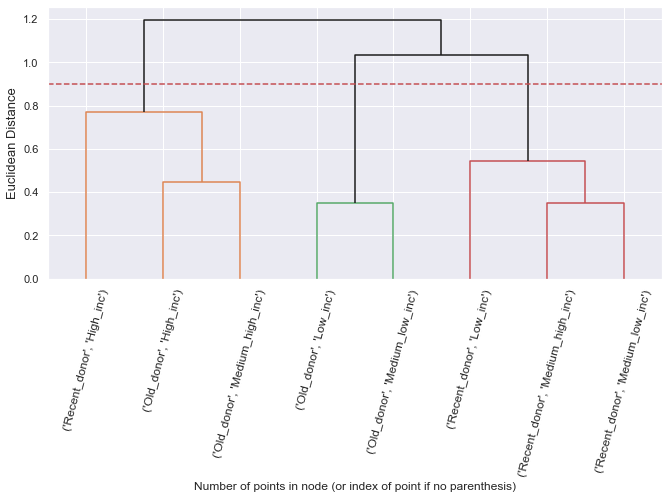

In [58]:
#  Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.9
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
#plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xticks(rotation = 75)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [59]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=3
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

1st_gift_date  Number_gifts  Amount_gifts  \
labels_gift  labels_neighborhood                                              
Old_donor    High_inc                  0.757310      0.259923      0.301955   
             Low_inc                   0.785114      0.291780      0.280139   
             Medium_high_inc           0.764486      0.272561      0.293161   
             Medium_low_inc            0.786608      0.290337      0.283021   
Recent_donor High_inc                  0.207250      0.062481      0.088006   
             Low_inc                   0.209208      0.070166      0.081826   
             Medium_high_inc           0.208982      0.067126      0.086008   
             Medium_low_inc            0.212262      0.070687      0.083815   

                                  Average_income   Poverty  2plus_vehicles  \
labels_gift  labels_neighborhood                                             
Old_donor    High_inc                   0.492804  0.074093        0.708929   
             Low_inc                    0.171546  0.378446        0.426506   
             Medium_high_inc            0.379441  0.079316        0.704632   
             Medium_low_inc             0.259651  0.160451        0.653803   
Recent_donor High_inc                   0.493907  0.076344        0.706140   
             Low_inc                    0.172558  0.398773        0.422137   
             Medium_high_inc            0.381272  0.080142        0.708806   
             Medium_low_inc             0.263630  0.161463        0.655981   

                                  Labor_Force  Education  Finance_labor  \
labels_gift  labels_neighborhood                                          
Old_donor    High_inc                0.681839   0.718048       0.395899   
             Low_inc                 0.533315   0.390060       0.181519   
             Medium_high_inc         0.707219   0.623826       0.329127   
             Medium_low_inc          0.645610   0.403780       0.182026   
Recent_donor High_inc                0.694371   0.716445       0.391395   
             Low_inc                 0.551563   0.386239       0.181298   
             Medium_high_inc         0.724374   0.621220       0.323804   
             Medium_low_inc          0.656122   0.403542       0.183636   

                                  House_value  Mortages  hclust_labels  
labels_gift  labels_neighborhood                                        
Old_donor    High_inc                0.630436  0.698286              0  
             Low_inc                 0.141590  0.310413              2  
             Medium_high_inc         0.291412  0.454235              0  
             Medium_low_inc          0.164519  0.349805              2  
Recent_donor High_inc                0.637100  0.699420              0  
             Low_inc                 0.151157  0.311397              1  
             Medium_high_inc         0.292537  0.457118              1  
             Medium_low_inc          0.170725  0.350865              1

In [60]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = merge_df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['labels_gift'], row['labels_neighborhood'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

1st_gift_date  Number_gifts  Amount_gifts  Average_income  \
merged_labels                                                              
0                   0.595656      0.206926      0.233290        0.436491   
1                   0.210543      0.069514      0.083964        0.275476   
2                   0.786087      0.290840      0.282016        0.228936   

                Poverty  2plus_vehicles  Labor_Force  Education  \
merged_labels                                                     
0              0.077379        0.705944     0.698286   0.670486   
1              0.196580        0.613376     0.650149   0.463019   
2              0.236449        0.574562     0.606461   0.398997   

               Finance_labor  House_value  Mortages  
merged_labels                                        
0                   0.361182     0.463036  0.576681  
1                   0.224122     0.201553  0.372192  
2                   0.181849     0.156526  0.336072

In [61]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['labels_gift'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['labels_neighborhood'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('labels_gift', 'labels_neighborhood', 0)

labels_neighborhood  High_inc  Medium_low_inc
labels_gift                                  
Old_donor                 NaN         26031.0
Recent_donor          18382.0         43877.0

## Clusters merge

In [62]:
# cluster 0 18382 - recent_donor/high income \ old_donor high and medium high income -> Above average Income

# cluster 1 43877 - recent_donor/low, medium_low, medium_high income->  Recent Donors

# cluster 2 26031 - old_donor low, medium_low income -> Old Below average Income

In [63]:
df_['merged_labels'] = df_['merged_labels'].map(lambda x: 'Above_Avg_Income' if x==0 else x)

In [64]:
df_['merged_labels'] = df_['merged_labels'].map(lambda x: 'Recent Donors' if x==1 else x)

In [65]:
df_['merged_labels'] = df_['merged_labels'].map(lambda x: 'Old_Below_Avg_Income' if x==2 else x)

In [66]:
df_.head()

1st_gift_date  Number_gifts  Amount_gifts  Average_income   Poverty  \
0       0.660870      0.588235      0.471933        0.269298  0.017241   
1       0.643478      0.509804      0.392931        0.220175  0.189655   
2       0.947826      0.294118      0.199584        0.338596  0.344828   
3       0.226087      0.058824      0.079002        0.319298  0.137931   
4       0.956522      0.254902      0.195426        0.220175  0.051724   

   2plus_vehicles  Labor_Force  Education  Finance_labor  House_value  \
0        0.777778     0.547368   0.382716       0.214286     0.143633   
1        0.656566     0.642105   0.382716       0.107143     0.123501   
2        0.434343     0.684211   0.382716       0.107143     0.285682   
3        0.727273     0.663158   0.382716       0.178571     0.203348   
4        0.565657     0.526316   0.382716       0.178571     0.117394   

   Mortages   labels_gift labels_neighborhood         merged_labels  
0      0.30     Old_donor      Medium_low_inc  Old_Below_Avg_Income  
1      0.45     Old_donor      Medium_low_inc  Old_Below_Avg_Income  
2      0.80     Old_donor      Medium_low_inc  Old_Below_Avg_Income  
3      0.45  Recent_donor      Medium_low_inc         Recent Donors  
4      0.25     Old_donor      Medium_low_inc  Old_Below_Avg_Income

In [67]:
df = df_.copy()

In [68]:
df

1st_gift_date  Number_gifts  Amount_gifts  Average_income   Poverty  \
0           0.660870      0.588235      0.471933        0.269298  0.017241   
1           0.643478      0.509804      0.392931        0.220175  0.189655   
2           0.947826      0.294118      0.199584        0.338596  0.344828   
3           0.226087      0.058824      0.079002        0.319298  0.137931   
4           0.956522      0.254902      0.195426        0.220175  0.051724   
...              ...           ...           ...             ...       ...   
88285       0.295652      0.039216      0.139293        0.196491  0.137931   
88286       0.626087      0.450980      0.141372        0.250000  0.293103   
88287       0.008696      0.000000      0.024948        0.379825  0.103448   
88288       0.000000      0.000000      0.014553        0.707018  0.120690   
88289       0.147826      0.117647      0.093555        0.230702  0.448276   

       2plus_vehicles  Labor_Force  Education  Finance_labor  House_value  \
0            0.777778     0.547368   0.382716       0.214286     0.143633   
1            0.656566     0.642105   0.382716       0.107143     0.123501   
2            0.434343     0.684211   0.382716       0.107143     0.285682   
3            0.727273     0.663158   0.382716       0.178571     0.203348   
4            0.565657     0.526316   0.382716       0.178571     0.117394   
...               ...          ...        ...            ...          ...   
88285        0.484848     0.378947   0.382716       0.107143     0.302194   
88286        0.727273     0.663158   0.382716       0.142857     0.197919   
88287        0.606061     0.810526   0.580247       0.250000     0.231848   
88288        0.848485     0.726316   0.876543       0.321429     0.389731   
88289        0.424242     0.684211   0.382716       0.178571     0.085275   

       Mortages   labels_gift labels_neighborhood         merged_labels  
0          0.30     Old_donor      Medium_low_inc  Old_Below_Avg_Income  
1          0.45     Old_donor      Medium_low_inc  Old_Below_Avg_Income  
2          0.80     Old_donor      Medium_low_inc  Old_Below_Avg_Income  
3          0.45  Recent_donor      Medium_low_inc         Recent Donors  
4          0.25     Old_donor      Medium_low_inc  Old_Below_Avg_Income  
...         ...           ...                 ...                   ...  
88285      0.15  Recent_donor             Low_inc         Recent Donors  
88286      0.30     Old_donor      Medium_low_inc  Old_Below_Avg_Income  
88287      0.80  Recent_donor     Medium_high_inc         Recent Donors  
88288      0.90  Recent_donor            High_inc      Above_Avg_Income  
88289      0.25  Recent_donor             Low_inc         Recent Donors  

[88290 rows x 14 columns]

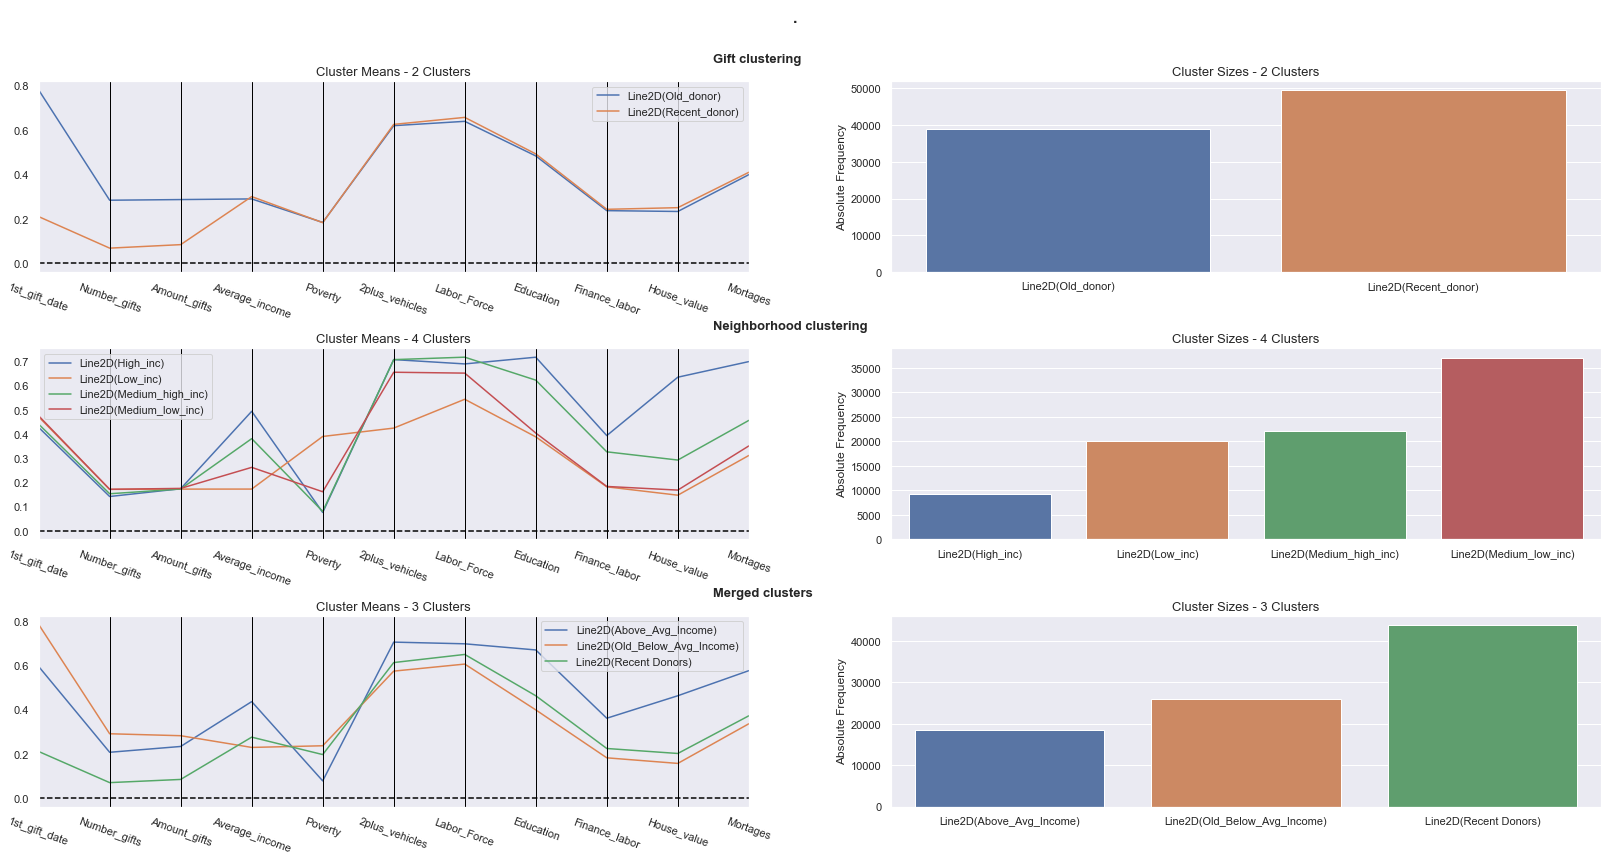

In [69]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features.to_list() + ['labels_gift', 'labels_neighborhood', 'merged_labels']], 
    label_columns = ['labels_gift', 'labels_neighborhood', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Gift clustering", "Neighborhood clustering", "Merged clusters"]
)

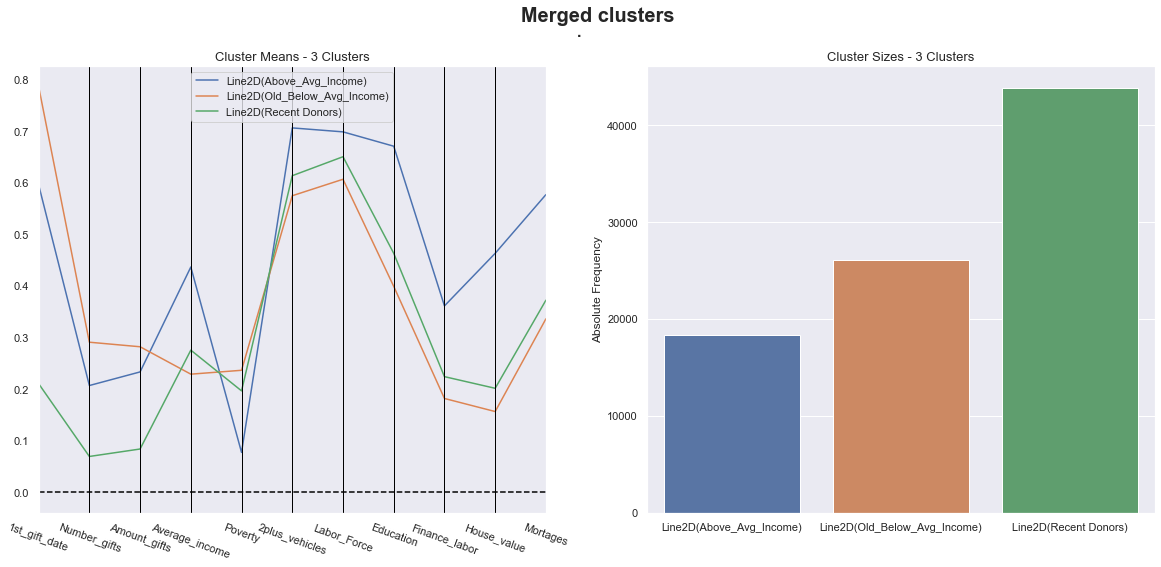

In [80]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features.to_list() + ['merged_labels']], 
    label_columns = ['merged_labels'], 
    figsize = (20, 8), 
    compar_titles = ["Merged clusters"]
)

## UMAP

In [ ]:
# standard_embedding = umap.UMAP(random_state=5).fit_transform(df_minmax[features_name])

In [ ]:
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=df_concat['labels'].astype(int), s=0.1, cmap='Spectral');

## T-SNE

In [ ]:
# # This is step can be quite time consuming
# two_dim = TSNE(random_state=5).fit_transform(df_minmax[features_name])

In [ ]:
# # t-SNE visualization
# pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_concat['labels'], colormap='tab10', figsize=(15,10))
# plt.show()